# Home Equity loans - Defaulter Prediction
BAD: 1 = applicant defaulted on loan or seriously delinquent; 0 = applicant paid loan
LOAN: Amount of the loan request
MORTDUE: Amount due on existing mortgage
VALUE: Value of current property
REASON: DebtCon = debt consolidation; HomeImp = home improvement
JOB: Occupational categories
YOJ: Years at present job
DEROG: Number of major derogatory reports
DELINQ: Number of delinquent credit lines
CLAGE: Age of oldest credit line in months
NINQ: Number of recent credit inquiries (
CLNO: Number of credit lines (present borrowing limit to the customers)
DEBTINC: Debt-to-income ratio (all debt / gross monthly income)

In [1]:
#libaries for basic function
import pandas as pd
import numpy as np
import os
os.chdir("E://python")

#Libaries for Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Libaries for DataPreProcessing
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import RandomOverSampler,SMOTE

#Libaries for Model Building
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

#Libaries for Model Fine tuning
from sklearn.model_selection import KFold,cross_val_score,GridSearchCV,RepeatedStratifiedKFold

#Libaries for Model Evaluation
from sklearn import metrics as m

import warnings
warnings.filterwarnings('ignore')

#Libaries for exporting models to Pickle file
import pickle
import json

In [2]:
#Importing CSV file
eq = pd.read_csv("Home Equity Loans.csv")

In [3]:
eq.head()
#There is lot of missing values in some columns

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


##Seems like there is Imbalanced in Data, will compare "Target Variable - BAD" with other columns

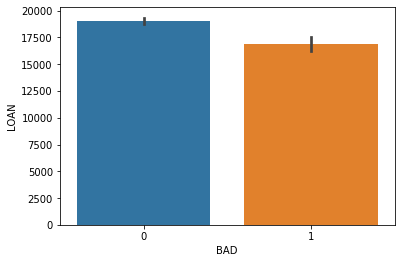

In [4]:
sns.barplot(x=eq['BAD'],y=eq['LOAN'])

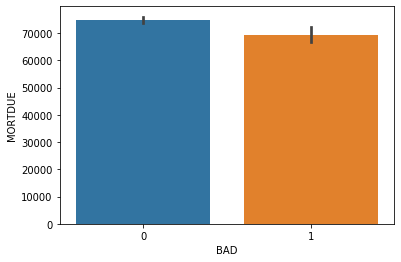

In [5]:
sns.barplot(x=eq['BAD'],y=eq['MORTDUE'])

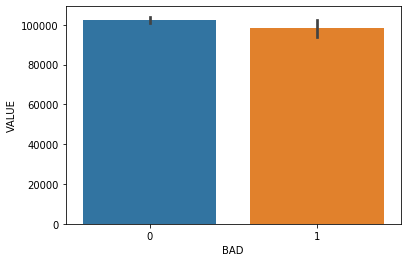

In [6]:
sns.barplot(x=eq['BAD'],y=eq['VALUE'])

# #Data Preprocessing

##There is missing value of more than 25% in DEBTINC it will impact our dataset, will drop the column. For other variables will use imputation to tackle the missing values

In [7]:
(eq.isna().sum()/eq.count())*100

BAD         0.000000
LOAN        0.000000
MORTDUE     9.518559
VALUE       1.915185
REASON      4.414856
JOB         4.911107
YOJ         9.458219
DEROG      13.480579
DELINQ     10.780669
CLAGE       5.449398
NINQ        9.357798
CLNO        3.868944
DEBTINC    26.997656
dtype: float64

In [8]:
equity = eq.drop(['DEBTINC'],axis=1)

In [9]:
equity.head(3)

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0


##For Imputation using mode, median method for the respective columns and filling the "NA". For "Value" variable i tried to use imputation but its not giving proper prediction, i decided to drop na for that variables.

In [10]:
modval = int(equity['DEROG'].mode())
equity['DEROG'] = equity['DEROG'].fillna(modval)

modval1 = int(equity['DELINQ'].mode())
equity['DELINQ'] = equity['DELINQ'].fillna(modval1)

medval = int(equity['NINQ'].median())
equity['NINQ'] = equity['NINQ'].fillna(medval)

medval1 = int(equity['CLNO'].median())
equity['CLNO'] = equity['CLNO'].fillna(medval1)

medval2 = int(equity['YOJ'].median())
equity['YOJ'] = equity['YOJ'].fillna(medval2)


In [11]:
equity.dropna(axis=0,how='any',inplace=True)

In [12]:
(equity.isna().sum()/equity.count())*100

BAD        0.0
LOAN       0.0
MORTDUE    0.0
VALUE      0.0
REASON     0.0
JOB        0.0
YOJ        0.0
DEROG      0.0
DELINQ     0.0
CLAGE      0.0
NINQ       0.0
CLNO       0.0
dtype: float64

##There is imbalance in our dataset, will try oversampling method for "1"

In [13]:
np.unique(equity['BAD'],return_counts=True)

(array([0, 1], dtype=int64), array([4016,  918], dtype=int64))

In [14]:
#equity.skew()

In [15]:
#equity.head(5)

##Before proceed for trying sampling methods, will do the label or onehot encoding for the categorical variables. For that i split the categorial,numerical & Target variable.

In [16]:
## taking copy of dataset
equity1 = equity.copy()

In [17]:
## Getting the Categorial variable
eq_f = equity1[['REASON','JOB']]

##Using Pandas Get Dummies option to encoding categorical variable

In [18]:
eq_f = pd.get_dummies(eq_f,columns=['REASON','JOB'],drop_first=True)
eq_f.head(3)

,REASON_HomeImp,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,0,1,0,0,0
1,1,0,1,0,0,0
2,1,0,1,0,0,0


In [19]:
eq_f.reset_index(drop=True,inplace=True)

In [20]:
eq_f.head(3)

,REASON_HomeImp,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,0,1,0,0,0
1,1,0,1,0,0,0
2,1,0,1,0,0,0


In [21]:
##Getting Target Variable
eq_target = equity[['BAD']]
print(eq_target.shape)
#eq_target.isna().sum()

(4934, 1)


##Splitting numerical variable for transformation using Scaling methods

In [22]:
eq_v = equity1.drop(['REASON','JOB','BAD'],axis='columns')
print(eq_v.shape)
eq_v.head(3)

(4934, 9)


,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO
0,1100,25860.0,39025.0,10.5,0.0,0.0,94.366667,1.0,9.0
1,1300,70053.0,68400.0,7.0,0.0,2.0,121.833333,0.0,14.0
2,1500,13500.0,16700.0,4.0,0.0,0.0,149.466667,1.0,10.0


In [23]:
eq_v.reset_index(drop=True,inplace=True)

##Done transformation using StandardScaler method

In [24]:
scaler = StandardScaler()

In [25]:
scaled_d = scaler.fit_transform(eq_v)
scaled_df = pd.DataFrame(scaled_d,columns=eq_v.columns)
scaled_df.shape

(4934, 9)

In [26]:
print(eq_f.shape)
print(eq_v.shape)
print(scaled_df.shape)
print(eq_target.shape)

(4934, 6)
(4934, 9)
(4934, 9)
(4934, 1)


##Combining categorial & numerical into final dataset

In [27]:
eq_final = pd.concat([eq_f,scaled_df],axis=1)
eq_final.head(3)
print(eq_final.shape)

(4934, 15)


##Since dataset is Imbalanced i used SMOTE - Synthetic Minority Oversampling
##Below Paragraph taken from Google Search
##"SMOTE first selects a minority class instance a at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors b at random and connecting a and b to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances a and b."

In [28]:
os = SMOTE(random_state=2)

In [29]:
X_reshape,y_reshape = os.fit_sample(eq_final,eq_target)

In [30]:
np.unique(y_reshape,return_counts=True)

(array([0, 1], dtype=int64), array([4016, 4016], dtype=int64))

##For detecting anomaly i used "IsolationForest" method

In [31]:
ic = IsolationForest(n_estimators=500,contamination=0.10)
iforest = ic.fit(X_reshape)

In [32]:
pred_if = iforest.predict(X_reshape)
pred_if

array([ 1,  1,  1, ..., -1,  1,  1])

In [33]:
eq_outliers = X_reshape[iforest.predict(X_reshape)==-1]
eq_outliers.shape

(804, 15)

In [34]:
eq_final1 = X_reshape[iforest.predict(X_reshape)== 1]
eq_final1.reset_index(drop=True,inplace=True)
eq_final1.shape

(7228, 15)

In [35]:
eq_target1 = y_reshape[iforest.predict(X_reshape)== 1]
eq_target1.reset_index(drop=True,inplace=True)
eq_target1.shape

(7228, 1)

In [36]:
X = eq_final1
y = eq_target1

# #Data Modelling

In [37]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [38]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5782, 15)
(5782, 1)
(1446, 15)
(1446, 1)


##for checking which models gives best, i created two function with calculating "Cross_val_score" one function using Kfold 5splits, score "recall"
##second function RepeatedStratifiedKFold 5 splits, repeated 3 & score "roc_auc".

In [39]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('XGB', XGBClassifier()))

In [40]:
results = []
names = []
scoring = 'recall'

for name, model in models:
    kfold = KFold(n_splits=5,random_state=1,shuffle=True)
    cv_results = cross_val_score(model,X_train,y_train,cv=kfold,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = (name,cv_results.mean(),cv_results.std())
    msg2 = (name,cv_results)
    #print("\n")
    #print(msg)
    #print(msg2)
    
model1 = pd.DataFrame(results)
model1.index = names
model1['Average'] = model1.mean(axis=1)
model_f=model1.sort_values(by='Average',ascending=False)
print(model_f)

             0         1         2         3         4   Average
RF    0.975265  0.961199  0.966431  0.948893  0.956672  0.961692
KNN   0.950530  0.947090  0.971731  0.965928  0.953206  0.957697
XGB   0.941696  0.945326  0.973498  0.936968  0.944541  0.948406
CART  0.906360  0.897707  0.902827  0.896082  0.890815  0.898758
SVM   0.803887  0.811287  0.812721  0.768313  0.767764  0.792795
LR    0.689046  0.686067  0.692580  0.701874  0.693241  0.692561
LDA   0.696113  0.691358  0.683746  0.691652  0.684575  0.689489
NB    0.500000  0.493827  0.482332  0.483816  0.485269  0.489049


In [41]:
results = []
names = []
scoring = 'roc_auc'

for name, model in models:
    kfold = RepeatedStratifiedKFold(n_splits=5,n_repeats=3,random_state=1)
    cv_results = cross_val_score(model,X_train,y_train,cv=kfold,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = (name,cv_results.mean(),cv_results.std())
    msg2 = (name,cv_results)
    #print("\n")
    #print(msg)
    #print(msg2)
    
model2 = pd.DataFrame(results)
model2.index = names
model2['Average'] = model2.mean(axis=1)
model_d=model2.sort_values(by='Average',ascending=False)
print(model_d)

             0         1         2         3         4         5         6  \
RF    0.997780  0.997053  0.997896  0.994525  0.992956  0.994788  0.997036   
KNN   0.990291  0.995900  0.993327  0.993963  0.992043  0.991370  0.991809   
XGB   0.994543  0.991408  0.997285  0.991732  0.986730  0.991220  0.994005   
CART  0.904869  0.917695  0.897182  0.911827  0.899572  0.884996  0.912706   
SVM   0.882581  0.870984  0.891671  0.885519  0.880267  0.863564  0.893142   
LR    0.809098  0.791454  0.821741  0.803908  0.795416  0.795178  0.823015   
LDA   0.804137  0.787659  0.819074  0.799367  0.792923  0.794455  0.819793   
NB    0.770159  0.769798  0.781829  0.768542  0.771983  0.754279  0.796225   

             7         8         9        10        11        12        13  \
RF    0.997842  0.992815  0.998086  0.995042  0.997957  0.995667  0.993029   
KNN   0.994830  0.992260  0.995743  0.994873  0.992498  0.993055  0.990199   
XGB   0.993516  0.992283  0.993325  0.991483  0.994044  0.99269

##2 functions gave average above 95% for "RandomForest","KnearestNeighbors","XGBoost".
##I choose 2 models "RandomForest" & "KnearestNeighbors" with fine tuning parameters.

In [42]:
#RF model
RF_model = RandomForestClassifier()
RF_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [43]:
RF_pred = RF_model.predict(X_test)

In [44]:
acc = m.accuracy_score(y_test,RF_pred)
acc

0.9799446749654218

In [45]:
cm = m.confusion_matrix(y_test,RF_pred)
cm

array([[735,  12],
       [ 17, 682]], dtype=int64)

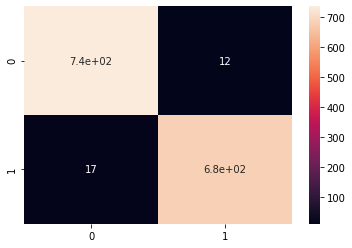

In [46]:
sns.heatmap(cm,annot=True)

In [47]:
print(m.classification_report(y_test,RF_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       747
           1       0.98      0.98      0.98       699

    accuracy                           0.98      1446
   macro avg       0.98      0.98      0.98      1446
weighted avg       0.98      0.98      0.98      1446



In [48]:
knn = KNeighborsClassifier()

In [49]:
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [50]:
knn_pred = knn.predict(X_test)
acc_knn = m.accuracy_score(y_test,knn_pred)
acc_knn

0.9737206085753803

In [51]:
knn_params = {'algorithm':['auto','ball_tree','kd_tree','brute'],'metric':['minkowski','euclidean','manhattan','seuclidean'],
             'n_neighbors':[5,6,7,8],'weights':['uniform','distance']}

In [52]:
knn_gs = GridSearchCV(knn,param_grid=knn_params)

In [53]:
knn_gs.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'metric': ['minkowski', 'euclidean', 'manhattan',
                                    'seuclidean'],
                         'n_neighbors': [5, 6, 7, 8],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [54]:
knn_gs.best_params_

{'algorithm': 'auto',
 'metric': 'manhattan',
 'n_neighbors': 5,
 'weights': 'distance'}

In [55]:
knn_gs_pred = knn_gs.predict(X_test)
acc_knn_gs = m.accuracy_score(y_test,knn_gs_pred)
acc_knn_gs

0.9944674965421854

In [56]:
print(m.classification_report(y_test,knn_gs_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       747
           1       0.99      0.99      0.99       699

    accuracy                           0.99      1446
   macro avg       0.99      0.99      0.99      1446
weighted avg       0.99      0.99      0.99      1446



In [57]:
cm_knn = m.confusion_matrix(y_test,knn_gs_pred)
cm_knn

array([[743,   4],
       [  4, 695]], dtype=int64)

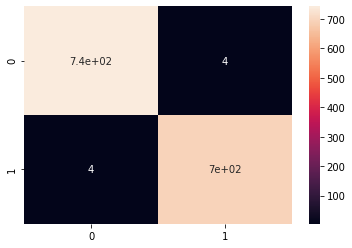

In [58]:
sns.heatmap(cm_knn,annot=True)

##Conclusion
##KNN_Gridsearch Model given accuracy of 99%

In [59]:
with open('Home_equity_model.pickle','wb') as f:
    pickle.dump(knn_gs,f)

In [60]:
X.columns

Index(['REASON_HomeImp', 'JOB_Office', 'JOB_Other', 'JOB_ProfExe', 'JOB_Sales',
       'JOB_Self', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ',
       'CLAGE', 'NINQ', 'CLNO'],
      dtype='object')

In [61]:

columns = {
    'data_columns': [col.lower() for col in X.columns]
}
with open("columns.json","w")as f:
    f.write(json.dumps(columns))